In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import SplineTransformer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
# import warnings
# warnings.filterwarnings('ignore')

# Import the permutation weighting implementation
from permutation_weighting.estimator import PW

class LaLondeSimulation:
    def __init__(self, n_simulations=48, n_test_points=100, n_bootstrap = 100):
        self.n_simulations = n_simulations
        self.n_test_points = n_test_points
        self.treatment_noise_sd = 5
        self.outcome_noise_sd = 10
        self.n_bootstrap = n_bootstrap
        
    def load_lalonde_data(self):
        """
        Load the LaLonde dataset (simplified version - in practice you would load the real dataset)
        For this example, we'll create a mock dataset with similar properties
        """
        try:
            # Try to load the real LaLonde data if available
            # This part would depend on where your data is stored
            from sklearn.datasets import fetch_openml
            lalonde = fetch_openml(name='lalonde', version=1, as_frame=True)
            df = lalonde.data
            df['treat'] = lalonde.target
            
            # Filter to keep only control units as in the paper
            df = df[(df['treat'] == 0) & (df['exper'] == 1) | (df['treat'] == 0) & (df['exper'] == 0)]
            
        except:
            # If real data is not available, create mock data with similar structure
            print("Creating mock LaLonde data")
            n = 2915
            np.random.seed(42)
            
            # Create features similar to LaLonde data
            age = np.random.normal(33, 11, n)
            educ = np.random.randint(6, 17, n)
            black = np.random.binomial(1, 0.8, n)
            hisp = np.random.binomial(1, 0.1, n)
            married = np.random.binomial(1, 0.2, n)
            nodegr = np.random.binomial(1, 0.7, n)
            re74 = np.random.exponential(5000, n) * np.random.binomial(1, 0.7, n)
            re75 = np.random.exponential(6000, n) * np.random.binomial(1, 0.7, n)
            re78 = np.random.exponential(7000, n)
            
            # Create the mock dataset
            df = pd.DataFrame({
                'age': age,
                'educ': educ,
                'black': black,
                'hisp': hisp,
                'married': married,
                'nodegr': nodegr,
                're74': re74,
                're75': re75,
                're78': re78,
                'exper': np.random.binomial(1, 0.3, n)
            })
        
        return df
    
    def create_lalonde_dgp(self, df=None, psbeta=None, obeta=None):
            """
            Create LaLonde data generating process similar to the paper
            """
            if df is None:
                df = self.load_lalonde_data()
                
            if psbeta is None:
                psbeta = np.random.normal(0, 1, 4)
                
            if obeta is None:
                obeta = np.random.normal(0, 1, 4)
                
            # Create a randomForest to predict experimental/observational status
            X = df[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75']]
            y = df['exper']
            
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X, y)
            g_hat = rf_model.predict_proba(X)[:, 1]
            
            # Create spline basis for the propensity score - control the spline output shape
            spline_transformer = SplineTransformer(n_knots=4, degree=3)
            P_tilde = spline_transformer.fit_transform(g_hat.reshape(-1, 1))
            
            # Make sure P_tilde has the same number of columns as psbeta length
            # Either adjust psbeta or P_tilde
            if P_tilde.shape[1] > len(psbeta):
                # Option 1: Extend psbeta to match P_tilde
                psbeta_extended = np.zeros(P_tilde.shape[1])
                psbeta_extended[:len(psbeta)] = psbeta
                psbeta = psbeta_extended
            elif P_tilde.shape[1] < len(psbeta):
                # Option 2: Use only the columns that we have
                P_tilde = P_tilde[:, :len(psbeta)]
            
            # Generate treatment
            dose = 1 + np.dot(P_tilde, psbeta)
            dose = dose + 0.01 * df['age']**2 - 0.3 * df['educ']**2
            dose = dose - 0.01 * np.log(df['re74'] + 0.01)**2 + 0.01 * np.log(df['re75'] + 0.01)**2
            
            # Add noise to treatment
            treatment_noise = np.random.normal(0, self.treatment_noise_sd, len(df))
            dose = dose + treatment_noise
            
            # Create spline basis for the treatment - make sure dimensions match
            if isinstance(dose, pd.Series):
                dose_array = dose.values
            else:
                dose_array = dose
                
            A_tilde = spline_transformer.fit_transform(dose_array.reshape(-1, 1))  
            
            # Make sure A_tilde has the same number of columns as obeta length
            if A_tilde.shape[1] > len(obeta):
                obeta_extended = np.zeros(A_tilde.shape[1])
                obeta_extended[:len(obeta)] = obeta
                obeta = obeta_extended
            elif A_tilde.shape[1] < len(obeta):
                A_tilde = A_tilde[:, :len(obeta)]
            
            # Generate outcome
            outcome = df['re78'].values.copy()  # Base outcome is re78 as in the paper
            outcome = outcome + np.dot(A_tilde, obeta)
            outcome = outcome + 0.1 * np.exp(0.7 * np.log(df['re74'] + 0.01) + 0.7 * np.log(df['re75'] + 0.01))
            
            # Add noise to outcome
            outcome_noise = np.random.normal(0, self.outcome_noise_sd, len(df))
            outcome = outcome + outcome_noise
            
            # Create a data-generating process object
            dgp = {
                'data': df,
                'draw_dose': lambda: dose + np.random.normal(0, self.treatment_noise_sd, len(df)),
                'draw_outcome': lambda A: self._outcome_function(df, A, spline_transformer, obeta),
                'draw_test_points': lambda n: self._generate_test_points(n),
                'ps_formula': 'Dose ~ age + educ + black + hisp + married + nodegr + re74 + re75'
            }
            
            # Add dose and outcome to data
            df['Dose'] = dose
            df['Outcome'] = outcome
            
            return dgp
        
    
    def _outcome_function(self, df, A, spline_transformer, obeta):
        """Helper function to generate outcomes for a given treatment value"""
        if isinstance(A, pd.Series):
            A_array = A.values
        else:
            A_array = A
        A_tilde = spline_transformer.transform(A_array.reshape(-1, 1))
        # Make sure A_tilde has the same number of columns as obeta length
        if A_tilde.shape[1] > len(obeta):
            # Use only first len(obeta) columns
            A_tilde = A_tilde[:, :len(obeta)]
        elif A_tilde.shape[1] < len(obeta):
            # Use only first A_tilde.shape[1] elements of obeta
            obeta = obeta[:A_tilde.shape[1]]
    
        outcome = df['re78'].values.copy()
        outcome = outcome + np.dot(A_tilde, obeta)
        outcome = outcome + 0.1 * np.exp(0.7 * np.log(df['re74'] + 0.01) + 0.7 * np.log(df['re75'] + 0.01))
        outcome_noise = np.random.normal(0, self.outcome_noise_sd, len(df))
        return outcome + outcome_noise
        
    def _generate_test_points(self, n):
        """Generate test points for evaluation"""
        q = np.linspace(0.05, 0.95, n)
        test_points = norm.ppf(q, scale=self.treatment_noise_sd)
        return test_points
    
    def compute_npcbps_weights(self, A, X):
        """
        Compute non-parametric covariate balancing propensity score (NPCBPS) weights
        for continuous treatments
        """
        # For continuous treatments
        # 1. Discretize treatment into bins for better handling
        n_bins = 5
        A_quantiles = np.percentile(A, np.linspace(0, 100, n_bins+1))
        A_binned = np.digitize(A, A_quantiles[1:-1])
        
        # 2. Calculate standardized treatment and covariate matrices
        scaler_x = StandardScaler()
        X_scaled = scaler_x.fit_transform(X)
        
        scaler_a = StandardScaler()
        A_scaled = scaler_a.fit_transform(A.reshape(-1, 1)).flatten()
        
        # 3. Create interaction terms (treatment × covariates)
        interactions = np.column_stack([A_scaled.reshape(-1, 1) * X_scaled[:, i] 
                                       for i in range(X_scaled.shape[1])])
        
        # 4. Combine all features into a design matrix for balance
        balance_features = np.column_stack([X_scaled, interactions])
        
        # 5. Calculate covariate means
        global_mean = np.mean(balance_features, axis=0)
        
        # 6. Calculate weights that minimize balance deviation
        from scipy.optimize import minimize
        
        def balance_objective(log_weights):
            weights = np.exp(log_weights - np.max(log_weights))  # Numerical stability
            weights = weights / np.sum(weights) * len(weights)    # Normalize
            
            # Calculate weighted means
            weighted_mean = np.average(balance_features, axis=0, weights=weights)
            
            # Calculate imbalance (mean deviation)
            imbalance = np.sqrt(np.mean((weighted_mean - global_mean)**2))
            
            # Add entropy regularization to avoid extreme weights
            entropy = np.sum(weights * np.log(weights + 1e-10))
            
            return imbalance + 0.01 * entropy
        
        # Initialize with uniform weights and optimize
        initial_log_weights = np.zeros(len(A))
        result = minimize(
            balance_objective, 
            initial_log_weights, 
            method='L-BFGS-B',
            options={'maxiter': 50}  # Increased from 5 for better optimization
        )
        
        # Extract and normalize final weights
        weights = np.exp(result.x - np.max(result.x))
        weights = weights / np.sum(weights) * len(weights)
        
        # Clip extreme weights
        upper_limit = np.percentile(weights, 99)
        lower_limit = np.percentile(weights, 1)
        weights = np.clip(weights, lower_limit, upper_limit)
        
        # Normalize again after clipping
        weights = weights / np.sum(weights) * len(weights)
        
        return weights
        
    def compute_ipsw_glm_weights(self, A, X):
        """Compute inverse propensity score weights using a linear model for continuous treatment"""
        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Standardize treatment for more stable results
        A_mean = np.mean(A)
        A_std = np.std(A)
        A_norm = (A - A_mean) / A_std
        
        # Fit a regularized linear regression model with more robust parameter tuning
        from sklearn.linear_model import LassoCV
        
        # Find optimal alpha via cross-validation
        lasso_cv = LassoCV(cv=5, random_state=42)
        lasso_cv.fit(X_scaled, A_norm)
        
        # Use optimal alpha
        from sklearn.linear_model import Lasso
        model = Lasso(alpha=lasso_cv.alpha_, random_state=42)
        model.fit(X_scaled, A_norm)
        
        # Predict treatment values
        pred_A_norm = model.predict(X_scaled)
        
        # Calculate residuals to estimate conditional variance
        residuals = A_norm - pred_A_norm
        sigma = np.std(residuals)
        
        # Compute density ratio weights
        # p(A) / p(A|X) using normal density
        # Improved stability with logpdf operations
        marginal_logpdf = norm.logpdf(A_norm, loc=0, scale=1)  # Marginal is N(0,1) for normalized A
        conditional_logpdf = norm.logpdf(A_norm, loc=pred_A_norm, scale=sigma)
        
        # Log density ratio
        log_weights = marginal_logpdf - conditional_logpdf
        
        # Stabilize weights with clipping
        log_weights = np.clip(log_weights, np.percentile(log_weights, 2), np.percentile(log_weights, 98))
        
        # Convert to weights
        weights = np.exp(log_weights)
        
        # Normalize
        weights = weights / np.sum(weights) * len(weights)
        
        return weights

    def compute_ipsw_gbm_weights(self, A, X):
        """Compute inverse propensity score weights using gradient boosting for continuous treatment"""
        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Standardize treatment for more stable results
        A_mean = np.mean(A)
        A_std = np.std(A)
        A_norm = (A - A_mean) / A_std
        
        # Fit a GBM regressor with better hyperparameters
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.model_selection import GridSearchCV
        
        # Define hyperparameter grid
        param_grid = {
            'learning_rate': [0.05, 0.1],
            'max_depth': [2, 3],
            'n_estimators': [100, 200]
        }
        
        # Find best hyperparameters with 3-fold CV
        gbm = GradientBoostingRegressor(random_state=42)
        grid_search = GridSearchCV(
            gbm, param_grid, cv=3, scoring='neg_mean_squared_error',
            n_jobs=-1, verbose=0
        )
        grid_search.fit(X_scaled, A_norm)
        
        # Use the best model
        best_gbm = grid_search.best_estimator_
        best_gbm.fit(X_scaled, A_norm)
        
        # Predict normalized treatment values
        pred_A_norm = best_gbm.predict(X_scaled)
        
        # Calculate residuals and estimate conditional variance
        # Use a robust variance estimation to handle potential heteroscedasticity
        residuals = A_norm - pred_A_norm
        
        # Estimate conditional variance with a second-stage model
        abs_residuals = np.abs(residuals)
        variance_model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=2,
            random_state=42
        )
        variance_model.fit(X_scaled, abs_residuals)
        
        # Predict conditional standard deviation
        pred_sigma = np.maximum(variance_model.predict(X_scaled), 0.1)  # Ensure positive values
        
        # Compute density ratio weights with heteroscedastic noise model
        # log[p(A)/p(A|X)]
        marginal_logpdf = norm.logpdf(A_norm, loc=0, scale=1)
        
        # For each observation, use its predicted mean and variance
        conditional_logpdf = np.array([
            norm.logpdf(A_norm[i], loc=pred_A_norm[i], scale=pred_sigma[i])
            for i in range(len(A_norm))
        ])
        
        # Log density ratio
        log_weights = marginal_logpdf - conditional_logpdf
        
        # Stabilize weights with quantile-based clipping
        low_quantile = np.percentile(log_weights, 2)
        high_quantile = np.percentile(log_weights, 98)
        log_weights = np.clip(log_weights, low_quantile, high_quantile)
        
        # Convert to weights
        weights = np.exp(log_weights)
        
        # Normalize
        weights = weights / np.sum(weights) * len(weights)
        
        return weights
    
    def compute_ipsw_gbm_weights(self, A, X):
        """Compute inverse propensity score weights using gradient boosting for continuous treatment"""
        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Standardize treatment for more stable results
        A_mean = np.mean(A)
        A_std = np.std(A)
        A_norm = (A - A_mean) / A_std
        
        # Fit a GBM regressor for continuous treatment
        from sklearn.ensemble import GradientBoostingRegressor
        
        model = GradientBoostingRegressor(
            n_estimators=100, 
            learning_rate=0.1, 
            max_depth=3,
            random_state=42
        )
        model.fit(X_scaled, A_norm)
    
        # Predict normalized treatment values
        pred_A_norm = model.predict(X_scaled)
        
        # Calculate residuals to estimate conditional variance
        residuals = A_norm - pred_A_norm
        sigma = np.std(residuals)
        
        # Compute density ratio weights
        # p(A) / p(A|X) using normal density
        marginal_logpdf = norm.logpdf(A_norm, loc=0, scale=1)  # Marginal is N(0,1) for normalized A
        conditional_logpdf = norm.logpdf(A_norm, loc=pred_A_norm, scale=sigma)
        
        # Log density ratio
        log_weights = marginal_logpdf - conditional_logpdf
        
        # Convert to weights, stabilize with clipping
        weights = np.exp(np.clip(log_weights, -10, 10))
        
        # Trim extreme weights
        weights_cap = np.percentile(weights, 99)
        weights = np.minimum(weights, weights_cap)
        
        # Normalize
        weights = weights / np.sum(weights) * len(weights)
        
        return weights
    
    def evaluate_weights(self, df, weights, truth, test_points):
        """Evaluate the performance of weights using different estimators"""
        # Get treatment and outcome
        A = df['Dose'].values
        Y = df['Outcome'].values
        
        # Normalize weights
        weights = weights / np.sum(weights) * len(weights)
        
        # Create a copy of the dataframe with weights
        df_weighted = df.copy()
        df_weighted['weights'] = weights
        
        # Define feature columns for consistency
        feature_cols = ['Dose', 'age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75']
        
        # Direct Method with OLS - using WLS model
        import statsmodels.api as sm
        X_matrix = sm.add_constant(df_weighted[feature_cols].values)  # Convert to numpy array explicitly
        wls_model = sm.WLS(df_weighted['Outcome'].values, X_matrix, weights=df_weighted['weights'].values)
        wls_result = wls_model.fit()
        
        # Predict outcomes for test points
        dm_ols_estimates = []
        for a in test_points:
            # Create a copy of X with the new dose value
            X_test = X_matrix.copy()
            X_test[:, 1] = a  # First column is constant, second is Dose
            
            # Predict outcomes
            predictions = wls_result.predict(X_test)
            dm_ols_estimates.append(np.mean(predictions))
        
        # Direct Method with Random Forest (using case weights)
        from sklearn.ensemble import RandomForestRegressor
        
        X_rf = df_weighted[feature_cols].values  # Numpy array for sklearn
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_rf, Y, sample_weight=weights)
        
        # Predict outcomes for test points
        dm_rf_estimates = []
        for a in test_points:
            X_test = X_rf.copy()
            X_test[:, 0] = a  # First column is Dose
            dm_rf_estimates.append(rf_model.predict(X_test).mean())
        
        # SIPW (self-implemented)
        sipw_estimates = []
        for a in test_points:
            # Use local regression to estimate at each test point
            # Adaptive bandwidth based on data density
            bandwidth = 0.15 * (np.max(A) - np.min(A))  # Increased bandwidth for smoother estimates
            kernel_weights = np.exp(-0.5 * ((A - a) / bandwidth)**2)
            combined_weights = weights * kernel_weights
            # Avoid division by zero
            sum_combined_weights = np.sum(combined_weights)
            if sum_combined_weights > 0:
                combined_weights = combined_weights / sum_combined_weights * len(combined_weights)
                sipw_estimates.append(np.sum(Y * combined_weights) / np.sum(combined_weights))
            else:
                # Fallback if weights are all zero (unlikely but possible)
                sipw_estimates.append(np.mean(Y))
        
        # Doubly Robust with OLS
        dr_ols_estimates = []
        for a in test_points:
            # Create a copy of X with the new dose value
            X_test = X_matrix.copy()
            X_test[:, 1] = a  # First column is constant, second is Dose
            
            # Predict outcomes
            mu_a = wls_result.predict(X_test)
            
            # Local regression for current test point
            bandwidth = 0.15 * (np.max(A) - np.min(A))
            kernel_weights = np.exp(-0.5 * ((A - a) / bandwidth)**2)
            combined_weights = weights * kernel_weights
            sum_combined_weights = np.sum(combined_weights)
            
            if sum_combined_weights > 0:
                combined_weights = combined_weights / sum_combined_weights * len(combined_weights)
                # Bias correction term
                orig_predictions = wls_result.predict(X_matrix)
                bias_correction = np.sum((Y - orig_predictions) * combined_weights)
                dr_ols_estimates.append(np.mean(mu_a) + bias_correction / np.sum(combined_weights))
            else:
                dr_ols_estimates.append(np.mean(mu_a))
        
        # Doubly Robust with RF
        dr_rf_estimates = []
        for a in test_points:
            X_test = X_rf.copy()
            X_test[:, 0] = a
            mu_a = rf_model.predict(X_test)
            
            # Local regression for current test point
            bandwidth = 0.15 * (np.max(A) - np.min(A))
            kernel_weights = np.exp(-0.5 * ((A - a) / bandwidth)**2)
            combined_weights = weights * kernel_weights
            sum_combined_weights = np.sum(combined_weights)
            
            if sum_combined_weights > 0:
                combined_weights = combined_weights / sum_combined_weights * len(combined_weights)
                # Bias correction term
                X_orig = X_rf.copy()
                bias_correction = np.sum((Y - rf_model.predict(X_orig)) * combined_weights)
                dr_rf_estimates.append(np.mean(mu_a) + bias_correction / np.sum(combined_weights))
            else:
                dr_rf_estimates.append(np.mean(mu_a))
        
        # Calculate difference from truth
        results = []
        
       
        
        for name, estimates in [
            ('SIPW', sipw_estimates),
            ('DM_OLS', dm_ols_estimates),
            ('DM_RF', dm_rf_estimates),
            ('DR_OLS', dr_ols_estimates),
            ('DR_RF', dr_rf_estimates)
        ]:
            # Calculate differences
            differences = (np.array(estimates) - np.array(truth)) 
            
            # Create result record
            results.append({
                'estimator': name.split('_')[0],
                'model': name.split('_')[1] if '_' in name else 'Model Free',
                'differences': differences,
                'rmse': np.sqrt(np.mean(differences**2)),
                'bias': np.mean(np.abs(differences))
            })
        
        return results
    
    def run_simulation(self, methods=None):
        """Run the complete simulation with multiple iterations"""
        if methods is None:
            methods = ['Unweighted', 'PW (GLM)', 'PW (GBM)', 'PW (MLP)', 'PW (SGD)', 'NPCBPS', 'IPSW (GLM)', 'IPSW (GBM)']
        
        results = []
        
        # Generate fixed betas for consistency across runs
        np.random.seed(100)
        psbeta = np.random.normal(0, 1, 4)
        obeta = np.random.normal(0, 1, 4)
        print(f"PS beta: {psbeta}")
        print(f"Outcome beta: {obeta}")
        
        for sim in range(self.n_simulations):
            print(f"Running simulation {sim+1}/{self.n_simulations}")
            
            # Create DGP
            dgp = self.create_lalonde_dgp(psbeta=psbeta, obeta=obeta)
            df = dgp['data']
            
            # Get treatment and covariates
            A = df['Dose'].values
            X = df[['age', 'educ', 'black', 'hisp', 'married', 'nodegr', 're74', 're75']].values
            
            # Generate test points and true outcomes
            test_points = dgp['draw_test_points'](self.n_test_points)
            truth = [np.mean(dgp['draw_outcome'](np.full(len(df), a))) for a in test_points]
            
            # Compute weights for each method
            all_weights = {}
            
            # Unweighted
            all_weights['Unweighted'] = np.ones(len(df))
            
            # Permutation Weighting with GLM
            if 'PW (GLM)' in methods:
                pw_glm = PW(A, X, classifier='logit', num_replicates=10)
                all_weights['PW (GLM)'] = pw_glm['weights']
            
            # Permutation Weighting with GBM
            if 'PW (GBM)' in methods:
                pw_gbm = PW(A, X, classifier='boosting', num_replicates=1)
                all_weights['PW (GBM)'] = pw_gbm['weights']
                
            # Permutation Weighting with MLP
            if 'PW (MLP)' in methods:
                pw_mlp = PW(A, X, classifier='mlp', num_replicates=1)
                all_weights['PW (MLP)'] = pw_mlp['weights']
                
            # Permutation Weighting with SGD
            if 'PW (SGD)' in methods:
                pw_sgd = PW(A, X, classifier='sgd', num_replicates=10)
                all_weights['PW (SGD)'] = pw_sgd['weights']
            
            # NPCBPS
            if 'NPCBPS' in methods:
                all_weights['NPCBPS'] = self.compute_npcbps_weights(A, X)
            
            # IPSW with GLM
            if 'IPSW (GLM)' in methods:
                all_weights['IPSW (GLM)'] = self.compute_ipsw_glm_weights(A, X)
            
            # IPSW with GBM
            if 'IPSW (GBM)' in methods:
                all_weights['IPSW (GBM)'] = self.compute_ipsw_gbm_weights(A, X)
            
            # Evaluate each method
            for method_name, weights in all_weights.items():
                method_results = self.evaluate_weights(df, weights, truth, test_points)
                
                # Add method name and simulation number
                for result in method_results:
                    result['method'] = method_name
                    result['simulation'] = sim
                
                results.extend(method_results)
        
        return pd.DataFrame(results)
    
    def compute_metrics(self, results, n_bootstrap=100):
        """Compute summary metrics from simulation results"""
        # Group by method, estimator, and model
        grouped = results.groupby(['method', 'estimator', 'model'])
        
        # Compute IRMSE and bias with bootstrap confidence intervals
        metrics = []
        
        for name, group in grouped:
            method, estimator, model = name
            
            # Bootstrap to get confidence intervals
            irmse_samples = []
            bias_samples = []
            
            for _ in range(n_bootstrap):
                # Sample simulations with replacement
                bootstrap_idx = np.random.choice(
                    group['simulation'].unique(), 
                    size=len(group['simulation'].unique()), 
                    replace=True
                )
                
                bootstrap_data = pd.concat([
                    group[group['simulation'] == idx] for idx in bootstrap_idx
                ])
                
                # Compute metrics
                irmse = np.mean([
                    np.sqrt(np.mean(d**2)) for d in bootstrap_data['differences']
                ])
                bias = np.mean([
                    np.mean(np.abs(d)) for d in bootstrap_data['differences']
                ])
                
                irmse_samples.append(irmse)
                bias_samples.append(bias)
            
            # Original metrics
            irmse = np.mean(group['rmse'])
            bias = np.mean(group['bias'])
            
            # Confidence intervals
            irmse_se = np.std(irmse_samples)
            bias_se = np.std(bias_samples)
            
            metrics.append({
                'method': method,
                'estimator': estimator,
                'model': model,
                'metric': 'Integrated RMSE',
                'value': irmse,
                'se': irmse_se,
                'lower': irmse - 1.96 * irmse_se,
                'upper': irmse + 1.96 * irmse_se
            })
            
            metrics.append({
                'method': method,
                'estimator': estimator,
                'model': model,
                'metric': 'Integrated Mean Absolute Bias',
                'value': bias,
                'se': bias_se,
                'lower': bias - 1.96 * bias_se,
                'upper': bias + 1.96 * bias_se
            })
        
        return pd.DataFrame(metrics)
   
    def plot_results(self, metrics, title="LaLonde Continuous Treatment Simulation", filename=None):
        """Plot the simulation results with column-specific optimized x-axes"""
        # Set the style
        try:
            plt.style.use('seaborn-whitegrid')
        except:
            plt.style.use('ggplot')  # Fallback style
        
        # Create a figure
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Define mapping between what's in your data and what you want to show
        estimator_mapping = {
            'DM': 'Direct Method',
            'DR': 'Doubly Robust',
            'SIPW': 'SIPW'
        }
        
        model_mapping = {
            'OLS': 'OLS',
            'RF': 'Random Forest',
            'Model Free': 'Model Free'
        }
        
        # Define the layout of subplots
        subplot_config = [
            (0, 0, 'DM', 'RF'),     # Row 0, Col 0: Direct Method - Random Forest
            (0, 1, 'DR', 'RF'),     # Row 0, Col 1: Doubly Robust - Random Forest
            (0, 2, 'SIPW', 'Model Free'),  # Row 0, Col 2: SIPW - Model Free
            (1, 0, 'DM', 'RF'),     # Row 1, Col 0: Direct Method - Random Forest (duplicate for RMSE)
            (1, 1, 'DR', 'RF'),     # Row 1, Col 1: Doubly Robust - Random Forest (duplicate for RMSE)
            (1, 2, 'SIPW', 'Model Free')   # Row 1, Col 2: SIPW - Model Free (duplicate for RMSE)
        ]
        
        # Colors for each method - ensure all methods have a unique color
        method_colors = {
            'Unweighted': 'black',
            'PW (GLM)': 'blue',
            'PW (GBM)': 'green',
            'PW (MLP)': 'purple',
            'PW (SGD)': 'cyan',
            'PW(GLM)': 'blue',      # Handle possible naming inconsistencies
            'PW(GBM)': 'green',
            'PW(MLP)': 'purple',
            'PW(SGD)': 'cyan',
            'NPCBPS': 'orange',
            'IPSW (GLM)': 'red',
            'IPSW (GBM)': 'brown'
        }
        
        # Plot each metric
        metrics_to_plot = ['Integrated Mean Absolute Bias', 'Integrated RMSE']
        
        # First, determine the x-axis ranges for each column
        column_ranges = {}
        for col in range(3):
            column_data = []
            for row_idx, metric_name in enumerate(metrics_to_plot):
                metric_data = metrics[metrics['metric'] == metric_name]
                for row, c, est, mod in subplot_config:
                    if row == row_idx and c == col:
                        data = metric_data[(metric_data['estimator'] == est) & 
                                           (metric_data['model'] == mod)]
                        column_data.extend(data['value'].tolist())
                        column_data.extend((data['value'] - 1.96 * data['se']).tolist())
                        column_data.extend((data['value'] + 1.96 * data['se']).tolist())
            
            if column_data:
                # Add some padding to the range
                min_val = max(0, min(column_data) * 0.9)  # Ensure we don't go below zero
                max_val = max(column_data) * 1.1
                column_ranges[col] = (min_val, max_val)
            else:
                column_ranges[col] = (0, 1000)  # Default range if no data
        
        # Now plot with column-specific ranges
        for row_idx, metric_name in enumerate(metrics_to_plot):
            metric_data = metrics[metrics['metric'] == metric_name]
            
            for row, col, est, mod in subplot_config:
                if row != row_idx:
                    continue  # Skip if we're not in the right row for this metric
                    
                ax = axes[row, col]
                
                # Get the data for this subplot
                data = metric_data[(metric_data['estimator'] == est) & 
                                   (metric_data['model'] == mod)]
                
                # Set the subplot title
                ax.set_title(f"{estimator_mapping[est]} - {model_mapping[mod]}")
                
                # Plot the data
                for method in sorted(metric_data['method'].unique()):
                    method_data = data[data['method'] == method]
                    if not method_data.empty:
                        # Horizontal error bars
                        ax.errorbar(
                            method_data['value'], 
                            [method],
                            xerr=1.96 * method_data['se'],
                            fmt='o',
                            capsize=5,
                            color=method_colors.get(method, 'gray'),
                            label=method if (row == 0 and col == 0) else ""
                        )
                
                # Set the optimized x-axis range for this column
                ax.set_xlim(*column_ranges[col])
                
                ax.set_ylabel("")
                ax.set_xlabel("Metric Value")
                ax.grid(True)
        
        # Add a single legend for the whole figure
        handles, labels = axes[0, 0].get_legend_handles_labels()
        if handles:  # Only add legend if we have handles
            fig.legend(handles, labels, loc='lower center', ncol=len(handles), 
                       bbox_to_anchor=(0.5, 0), fontsize=10)
        
        # Add row labels for metrics
        fig.text(0.01, 0.75, 'Integrated Mean Absolute Bias', va='center', rotation='vertical', fontsize=12)
        fig.text(0.01, 0.25, 'Integrated RMSE', va='center', rotation='vertical', fontsize=12)
        
        plt.tight_layout(rect=[0.02, 0.05, 1, 1])
        plt.suptitle(title, fontsize=16, y=1.02)
        
        if filename:
            plt.savefig(filename, bbox_inches='tight', dpi=300)
        
        plt.show()
        
        # Create a simplified plot similar to Figure 3 - all methods in SIPW column
        # Also with optimized x-axis
        plt.figure(figsize=(12, 5))
        
        # Get data for SIPW plots
        bias_data = metrics[(metrics['metric'] == 'Integrated Mean Absolute Bias') & 
                            (metrics['estimator'] == 'SIPW') & 
                            (metrics['model'] == 'Model Free')]
        
        rmse_data = metrics[(metrics['metric'] == 'Integrated RMSE') & 
                           (metrics['estimator'] == 'SIPW') & 
                           (metrics['model'] == 'Model Free')]
        
        # Calculate x-axis limits with padding
        if not bias_data.empty:
            bias_min = max(0, bias_data['value'].min() * 0.9)
            bias_max = bias_data['value'].max() * 1.1
            # Also consider error bars
            bias_min = min(bias_min, (bias_data['value'] - 1.96 * bias_data['se']).min() * 0.9)
            bias_max = max(bias_max, (bias_data['value'] + 1.96 * bias_data['se']).max() * 1.1)
        else:
            bias_min, bias_max = 0, 1000
            
        if not rmse_data.empty:
            rmse_min = max(0, rmse_data['value'].min() * 0.9)
            rmse_max = rmse_data['value'].max() * 1.1
            # Also consider error bars
            rmse_min = min(rmse_min, (rmse_data['value'] - 1.96 * rmse_data['se']).min() * 0.9)
            rmse_max = max(rmse_max, (rmse_data['value'] + 1.96 * rmse_data['se']).max() * 1.1)
        else:
            rmse_min, rmse_max = 0, 1000
        
        # Plot Integrated Mean Absolute Bias
        plt.subplot(1, 2, 1)
        # Sort methods for consistent order
        all_methods = sorted(metrics['method'].unique())
        for method in all_methods:
            data = bias_data[bias_data['method'] == method]
            
            if not data.empty:
                plt.errorbar(
                    data['value'], 
                    [method],
                    xerr=1.96 * data['se'],
                    fmt='o',
                    capsize=5,
                    color=method_colors.get(method, 'gray')
                )
        
        plt.title('Integrated Mean Absolute Bias')
        plt.xlabel('Value (in thousands)')
        plt.xlim(bias_min, bias_max)
        plt.grid(True)
        
        # Plot Integrated RMSE
        plt.subplot(1, 2, 2)
        for method in all_methods:
            data = rmse_data[rmse_data['method'] == method]
            
            if not data.empty:
                plt.errorbar(
                    data['value'], 
                    [method],
                    xerr=1.96 * data['se'],
                    fmt='o',
                    capsize=5,
                    color=method_colors.get(method, 'gray')
                )
        
        plt.title('Integrated Root Mean Square Error')
        plt.xlabel('Value (in thousands)')
        plt.xlim(rmse_min, rmse_max)
        plt.grid(True)
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(f"{filename}_fig3.png", bbox_inches='tight', dpi=300)
            
        plt.show()

In [2]:
def run_lalonde_simulation(n_simulations=1, test_run=True):
    """
    Run the LaLonde simulation with continuous treatment
    
    Parameters:
    -----------
    n_simulations : int
        Number of simulation runs
    test_run : bool
        If True, use fewer methods for faster execution
    
    Returns:
    --------
    dict
        Results and metrics from the simulation
    """
    # Configure simulation
    if test_run:
        methods = ['Unweighted', 'IPSW (GBM)', 'PW (GLM)', 'IPSW (GBM)', 'PW (GBM)', 'PW (MLP)', 'PW (SGD)']
        title_suffix = " (Test Run)"
        n_test_points = 50
        n_bootstrap = 50
    else:
        methods = ['Unweighted', 'PW (GLM)', 'PW (GBM)', 'NPCBPS', 'IPSW (GLM)', 'IPSW (GBM)']
        title_suffix = ""
        n_test_points = 100
        n_bootstrap = 100

    # Run simulation
    np.random.seed(42)
    simulation = LaLondeSimulation(n_simulations=n_simulations, n_test_points=n_test_points, n_bootstrap = n_bootstrap )
   

    print("Running LaLonde simulation...")
    results = simulation.run_simulation(methods=methods)
    metrics = simulation.compute_metrics(results)

    # Plot results
    simulation.plot_results(
        metrics,
        title=f"LaLonde Continuous Treatment Simulation{title_suffix}",
        filename=f"lalonde_continuous{'_test' if test_run else ''}"
    )

    return {
        'results': results,
        'metrics': metrics
    }


Running test simulation...
Running LaLonde simulation...
PS beta: [-1.74976547  0.3426804   1.1530358  -0.25243604]
Outcome beta: [ 0.98132079  0.51421884  0.22117967 -1.07004333]
Running simulation 1/5
Creating mock LaLonde data
Running simulation 2/5
Creating mock LaLonde data
Running simulation 3/5
Creating mock LaLonde data
Running simulation 4/5
Creating mock LaLonde data
Running simulation 5/5
Creating mock LaLonde data


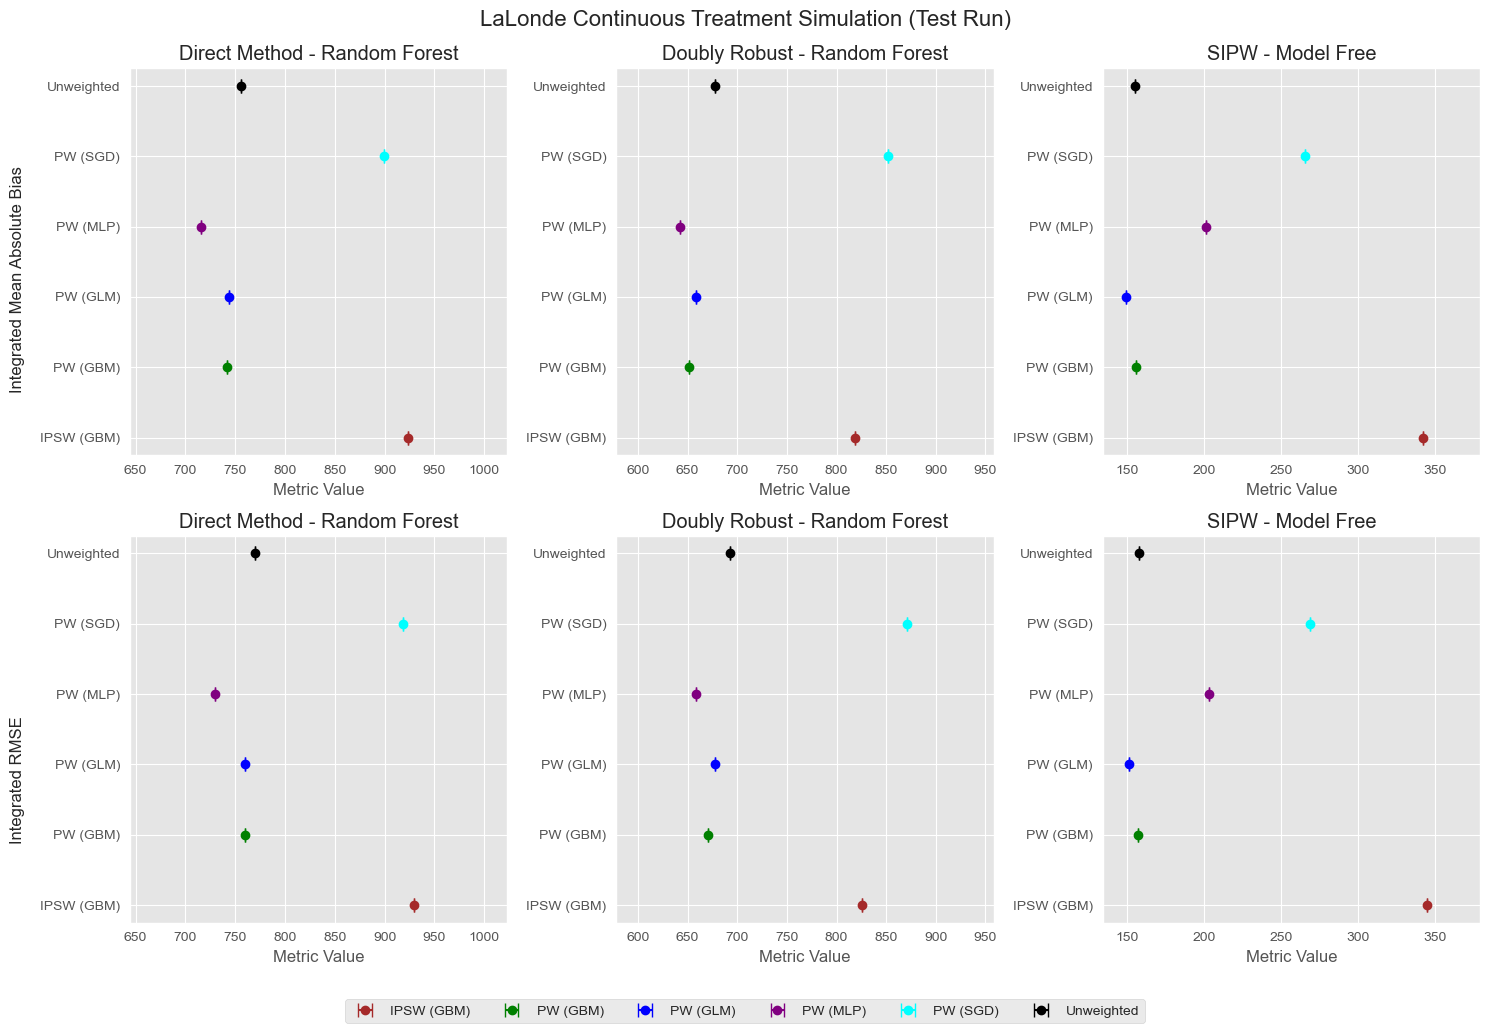

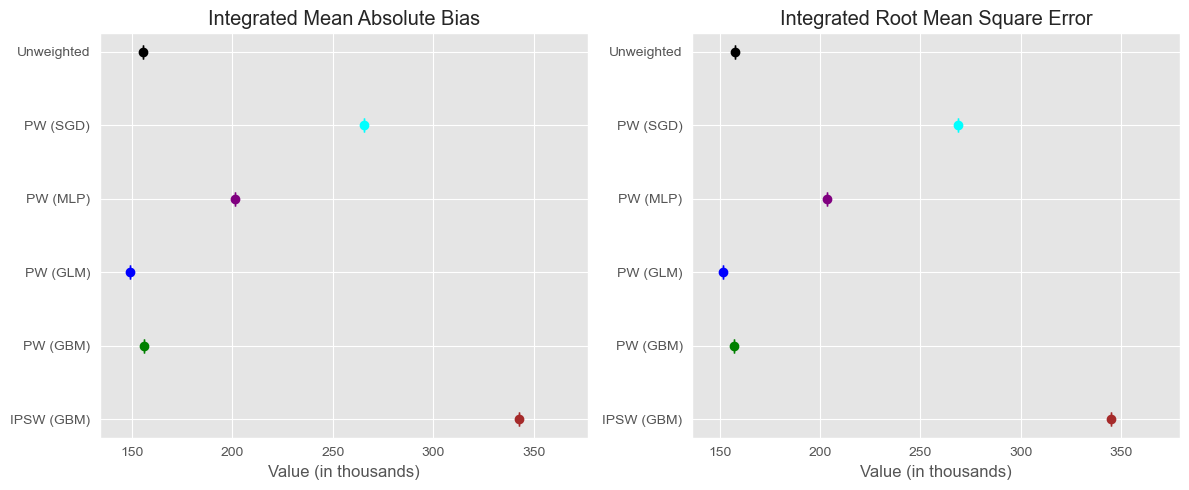

In [3]:
if __name__ == "__main__":
    # Run a test simulation first to make sure everything works
    print("Running test simulation...")
    test_results = run_lalonde_simulation(n_simulations=5, test_run=True)
    
    # Uncomment to run the full simulation
    # print("\nRunning full simulation...")
    # full_results = run_lalonde_simulation(n_simulations=48, test_run=False)